In [32]:
import sys
sys.path.append('..')

from datasets import Dataset, load_dataset

import importlib
to_dataloaders_for_training = importlib.reload(importlib.import_module('src.dataset')).to_dataloaders_for_training

# Test out new way of loading and preprocessing dataset splits to dataloaders

train_dataset: Dataset = load_dataset("tkarr/sprite_caption_dataset", split="train")
val_dataset: Dataset = load_dataset("tkarr/sprite_caption_dataset", split="valid")

train_dataloader, val_dataloader = to_dataloaders_for_training(train_dataset, val_dataset, image_pixel_size=64, batch_size=10)

In [42]:
# count number of images in train and val dataloaders
# compute checksum of all images in train and val dataloaders
import hashlib
img_checksums = set()
train_count = 0
val_count = 0
train_dupes_found = 0
val_dupes_found = 0
for batch in train_dataloader:
    for t in batch["tensor"]:
        hash = hashlib.md5(t.numpy().tobytes()).hexdigest()
        if hash in img_checksums:
            train_dupes_found += 1
        img_checksums.add(hash)
        train_count += 1
for batch in val_dataloader:
    for t in batch["tensor"]:
        hash = hashlib.md5(t.numpy().tobytes()).hexdigest()
        if hash in img_checksums:
            val_dupes_found += 1
        img_checksums.add(hash)
        val_count += 1

print(f'train count: {train_count}')
print(f'val count: {val_count}')
print(f'train dupes found: {train_dupes_found}')
print(f'val dupes found: {val_dupes_found}')
print(f'number of unique checksums: {len(set(img_checksums))}')

train count: 904
val count: 436
train dupes found: 0
val dupes found: 435
number of unique checksums: 905


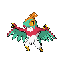

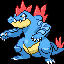

In [34]:
from src.utils import tensor_batch_to_pil_images

for batch in train_dataloader:
    display(tensor_batch_to_pil_images(batch["tensor"])[0])
    break

for batch in val_dataloader:
    display(tensor_batch_to_pil_images(batch["tensor"])[0])
    break

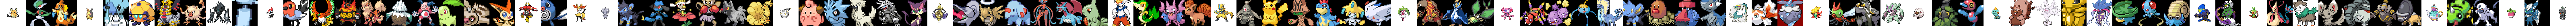

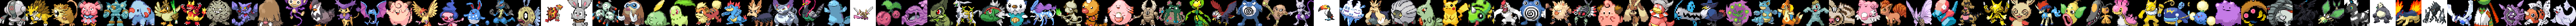

In [35]:
import random
from PIL import Image
from IPython.display import display
from torch.utils.data import DataLoader

from src.utils import tensor_to_pil_image, pil_image_concat


def sample_images_from_dataloader(dataloader: DataLoader, num_samples: int = 100):
    images = []
    for batch in dataloader:
        for t in batch["tensor"]:
            img: Image.Image = tensor_to_pil_image(t)
            images.append(img)
        if len(images) >= num_samples:
            break
    return random.sample(images, min(num_samples, len(images)))

sample_train_images = sample_images_from_dataloader(train_dataloader)
sample_val_images = sample_images_from_dataloader(val_dataloader)

train_concat_image = pil_image_concat(sample_train_images)
val_concat_image = pil_image_concat(sample_val_images)

display(train_concat_image)
display(val_concat_image)


In [36]:
# define a function for detecting if an image has a white background
def has_white_background(image: Image.Image) -> bool:
    # Get the image size
    width, height = image.size
    # Check the border corners
    border_pixels = [
        image.getpixel((0, 0)),  # top-left corner
        image.getpixel((width-1, 0)),  # top-right corner
        image.getpixel((0, height-1)),  # bottom-left corner
        image.getpixel((width-1, height-1))  # bottom-right corner
    ]
    # Count white and black pixels
    white_count = sum(1 for pixel in border_pixels if all(c >= 250 for c in pixel))
    black_count = sum(1 for pixel in border_pixels if all(c <= 5 for c in pixel))
    # print(f'white_count: {white_count}, black_count: {black_count}')
    # If most border pixels are white, it has a white background
    total_border_pixels = len(border_pixels)
    if white_count > 0.8 * total_border_pixels:
        return True
    elif black_count > 0.8 * total_border_pixels:
        return False
    return False

# test on the first image in the train dataloader
print(has_white_background(tensor_to_pil_image(train_dataloader.dataset[0]["tensor"])))


False


In [37]:
# count number of images with white background in train and val dataloaders
train_white_background_count = 0
for batch in train_dataloader:
    for t in batch["tensor"]:
        if has_white_background(tensor_to_pil_image(t)):
            train_white_background_count += 1

val_white_background_count = 0
for batch in val_dataloader:
    for t in batch["tensor"]:
        if has_white_background(tensor_to_pil_image(t)):
            val_white_background_count += 1

train_total_images = len(train_dataloader.dataset)
val_total_images = len(val_dataloader.dataset)

train_white_ratio = train_white_background_count / train_total_images
val_white_ratio = val_white_background_count / val_total_images

print(f'train dataloader white background ratio: {train_white_ratio:.2f}')
print(f'val dataloader white background ratio: {val_white_ratio:.2f}')

train dataloader white background ratio: 0.23
val dataloader white background ratio: 0.09
